In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd /content/drive/My Drive/Colab Notebooks/RoadWorksAnalyzer/data/

/content/drive/My Drive/Colab Notebooks/RoadWorksAnalyzer/data


In [3]:
import re

import pandas as pd
import numpy as np
import folium
import geopandas as gpd
from shapely.geometry import LineString


import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('Moscow_all_processed_data.csv', sep='^')
df.head()

,global_id,Address,AdmArea,District,WorksType,WorksStatus,Customer,ActualBeginDate,WorksBeginDate,ActualEndDate,PlannedEndDate,Lanes_closed,geoData,WorkYear
0,2639121078,"Фрунзенская наб., д.8",Центральный административный округ,район Хамовники,"Ремонтные работы, Работы ДЖКХ",идут,Unknown,2024-02-19,2024-02-19,2025-05-20,2025-05-20,1,"[[37.595787445, 55.732870129], [37.59622944, 5...",2025
1,2639494326,ул. Большая Академическая (ул. Валаамская - ул...,Северный административный округ,Тимирязевский район,"Ремонтные работы, Работы коммерческих организаций",закончены,Unknown,2024-01-15,2024-01-15,2024-12-08,2024-12-08,1,"[[37.560100034, 55.84447127], [37.560007415, 5...",2024
2,2639494348,ул. Новослободская (в сторону области) (ул. Па...,Центральный административный округ,Тверской район,"Ремонтные работы, Работы коммерческих организаций",закончены,Unknown,2024-05-29,2024-05-29,2024-11-19,2024-11-19,1,"[[37.597433083, 55.783436047], [37.597221136, ...",2024
3,2639494385,"ул. Маршала Тухачевского, д.15 - д.14, к.1",Северо-Западный административный округ,район Хорошёво-Мнёвники,"Ремонтные работы, Работы ДЖКХ",закончены,Unknown,2024-02-07,2024-02-07,2024-06-30,2024-06-30,1,"[[37.486243397, 55.781979222], [37.48678118, 5...",2024
4,2639494387,"Зелёный пр-кт, д.76",Восточный административный округ,район Новогиреево,"Ремонтные работы, Работы ДЖКХ",закончены,Unknown,2023-10-19,2023-10-19,2024-11-30,2024-11-30,1,"[[37.829881509, 55.74968833], [37.830577344, 5...",2024


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6264 entries, 0 to 6263
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   global_id        6264 non-null   int64 
 1   Address          6264 non-null   object
 2   AdmArea          6264 non-null   object
 3   District         6264 non-null   object
 4   WorksType        6264 non-null   object
 5   WorksStatus      6264 non-null   object
 6   Customer         6264 non-null   object
 7   ActualBeginDate  6159 non-null   object
 8   WorksBeginDate   6264 non-null   object
 9   ActualEndDate    5938 non-null   object
 10  PlannedEndDate   6264 non-null   object
 11  Lanes_closed     6264 non-null   int64 
 12  geoData          6264 non-null   object
 13  WorkYear         6264 non-null   int64 
dtypes: int64(3), object(11)
memory usage: 685.2+ KB


In [ ]:
pd.to_datetime(df['ActualBeginDate']).min()

pd.to_datetime(df['ActualEndDate']).max()

Timestamp('2027-09-21 00:00:00')

Количество начатых и выполненных работ по месяцам

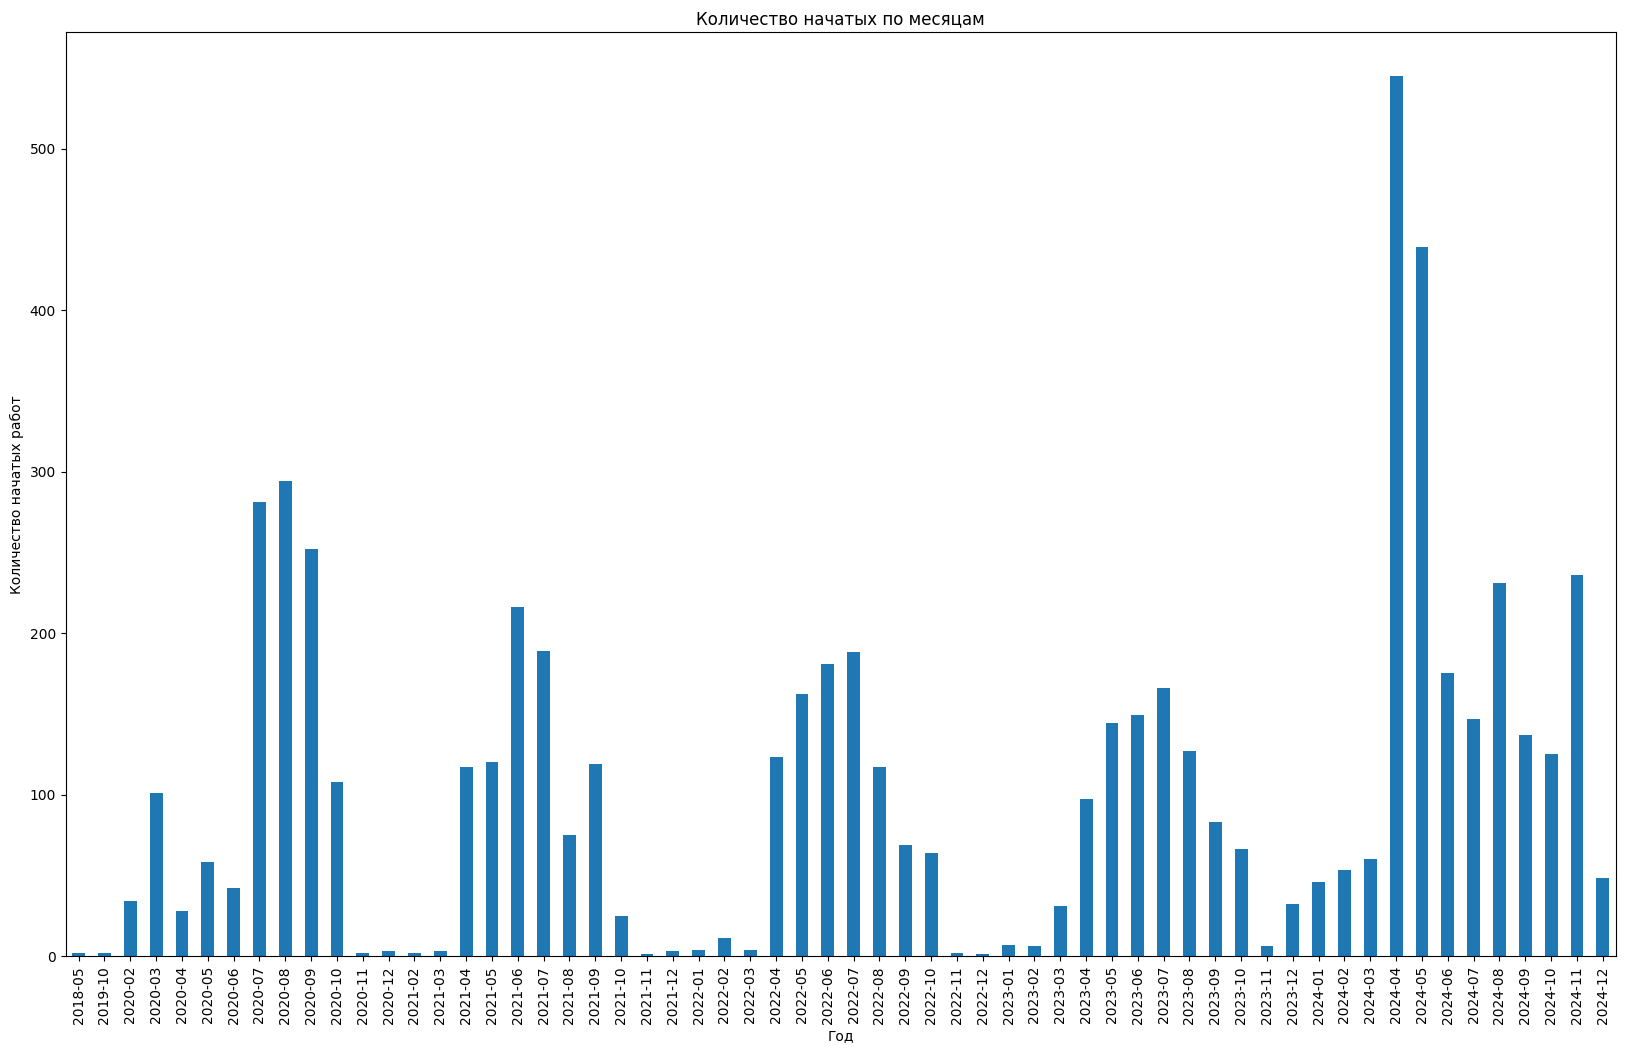

In [ ]:
df['YearMonthActualBeginDate'] = pd.to_datetime(df['ActualBeginDate']).dt.strftime('%Y-%m')

plt.figure(figsize=(20, 12))
df['YearMonthActualBeginDate'].value_counts().sort_index().plot(kind='bar')
plt.title('Количество начатых по месяцам')
plt.xlabel('Год')
plt.ylabel('Количество начатых работ')
plt.show()

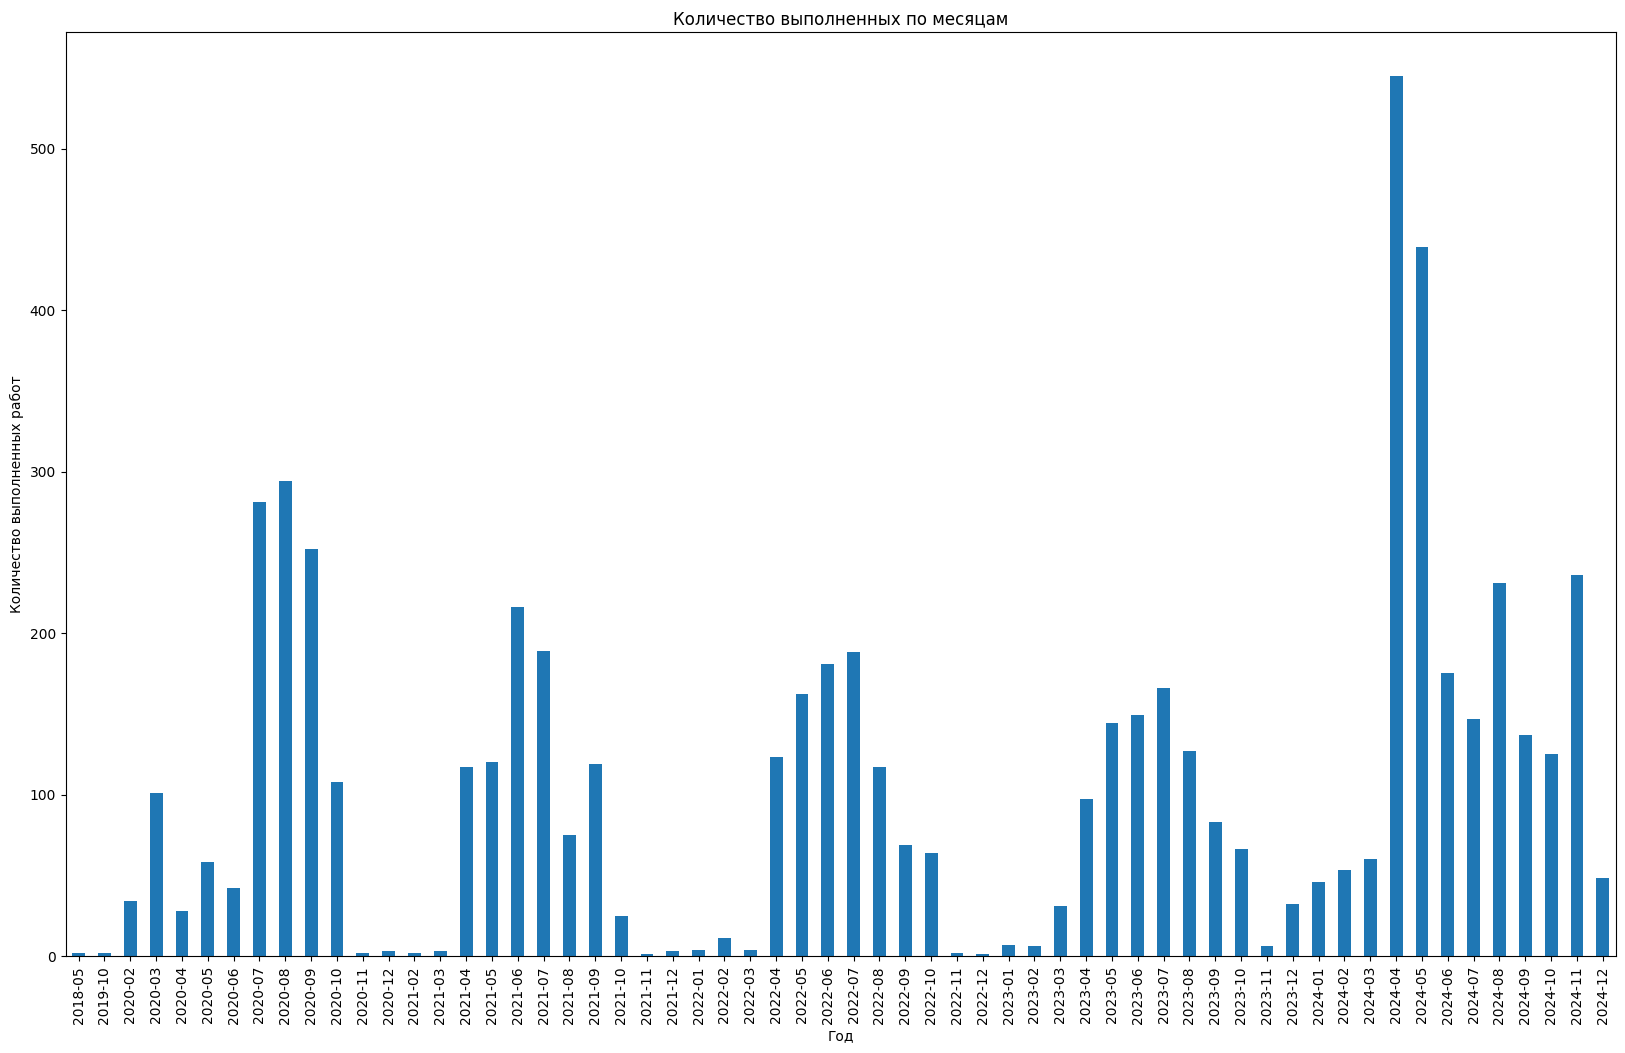

In [ ]:
df['YearMonthActualEndDate'] = pd.to_datetime(df['ActualEndDate']).dt.strftime('%Y-%m')

plt.figure(figsize=(20, 12))
df['YearMonthActualBeginDate'].value_counts().sort_index().plot(kind='bar')
plt.title('Количество выполненных по месяцам')
plt.xlabel('Год')
plt.ylabel('Количество выполненных работ')
plt.show()

Доля работ, которые начались позже срока и доля работ, которые закончились позже срока

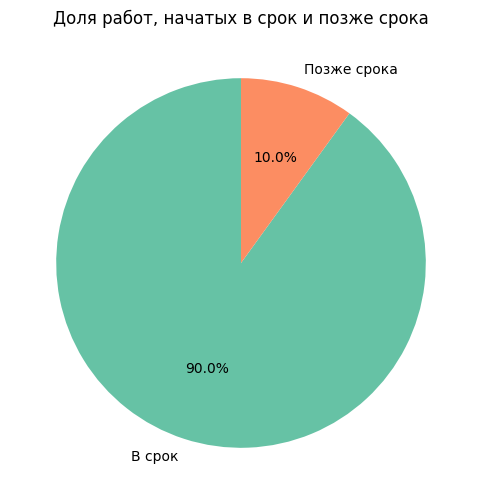

In [ ]:
df['ActualBeginDate'] = pd.to_datetime(df['ActualBeginDate'])
df['WorksBeginDate'] = pd.to_datetime(df['WorksBeginDate'])

df['StatusBegin'] = df.apply(lambda row: 'В срок' if row['WorksBeginDate'] <= row['ActualBeginDate'] else 'Позже срока', axis=1)
status_counts = df['StatusBegin'].value_counts()

plt.figure(figsize=(8, 6))
status_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#66c2a5', '#fc8d62'])
plt.title('Доля работ, начатых в срок и позже срока')
plt.ylabel('')
plt.show()

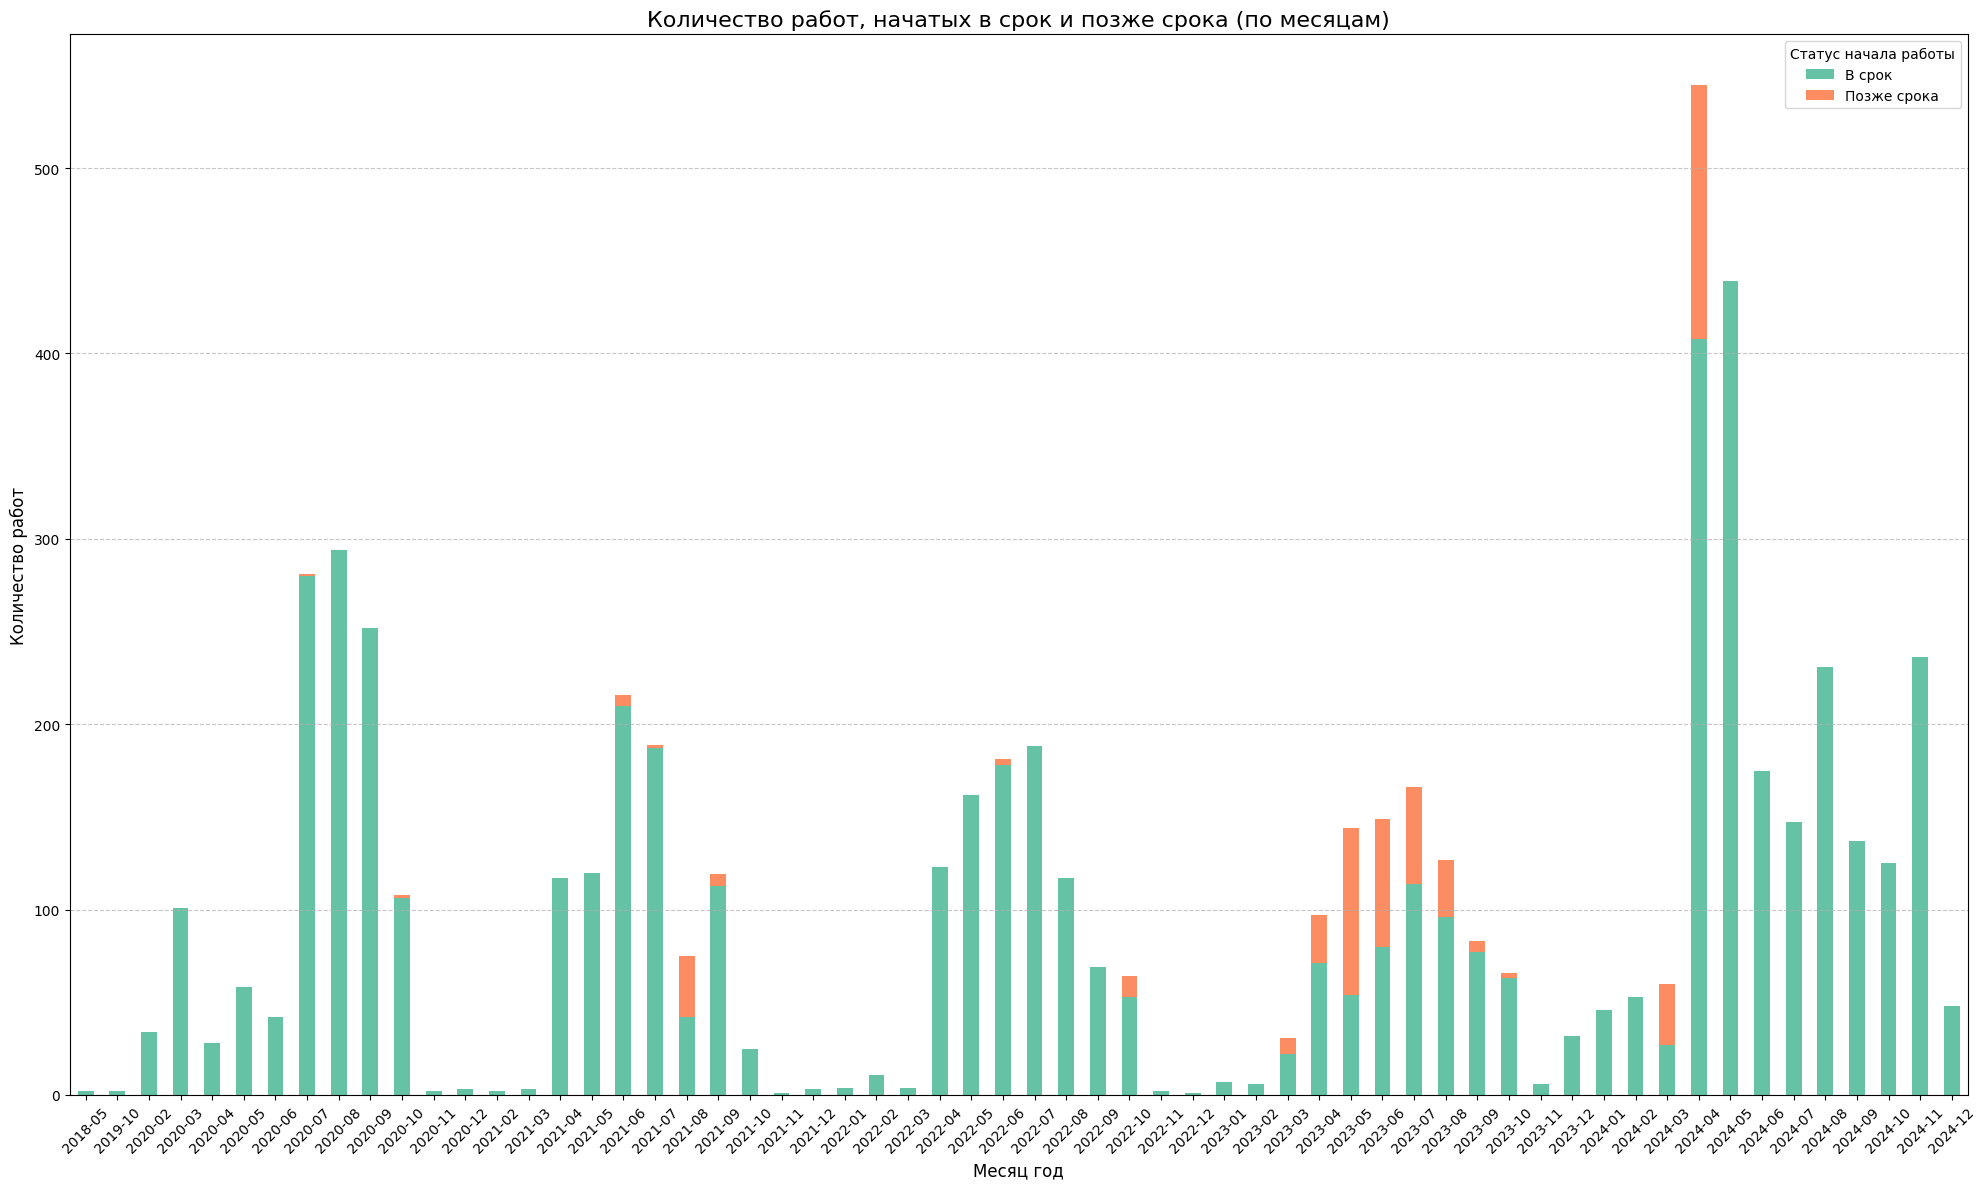

In [ ]:
status_counts = df.groupby(['YearMonthActualBeginDate', 'StatusBegin']).size().unstack(fill_value=0)

status_counts.plot(kind='bar', stacked=True, figsize=(20, 12), color=['#66c2a5', '#fc8d62'])

plt.title('Количество работ, начатых в срок и позже срока (по месяцам)', fontsize=16)
plt.xlabel('Месяц год', fontsize=12)
plt.ylabel('Количество работ', fontsize=12)
plt.legend(title='Статус начала работы')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


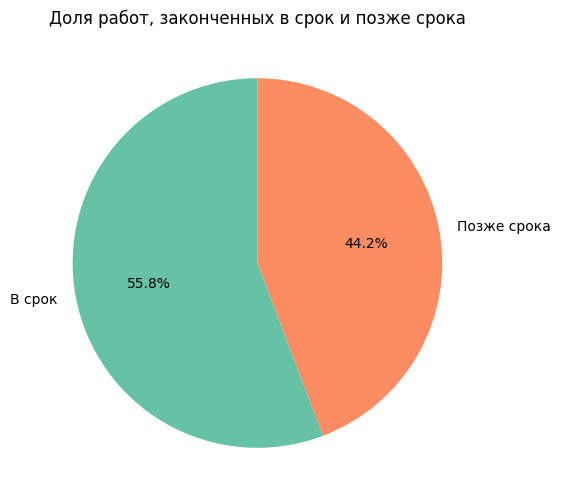

In [ ]:
df['ActualEndDate'] = pd.to_datetime(df['ActualEndDate'])
df['PlannedEndDate'] = pd.to_datetime(df['PlannedEndDate'])

df['StatusEnd'] = df.apply(lambda row: 'В срок' if row['PlannedEndDate'] <= row['ActualEndDate'] else 'Позже срока', axis=1)
status_counts = df['StatusEnd'].value_counts()

plt.figure(figsize=(8, 6))
status_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#66c2a5', '#fc8d62'])
plt.title('Доля работ, законченных в срок и позже срока')
plt.ylabel('')
plt.show()

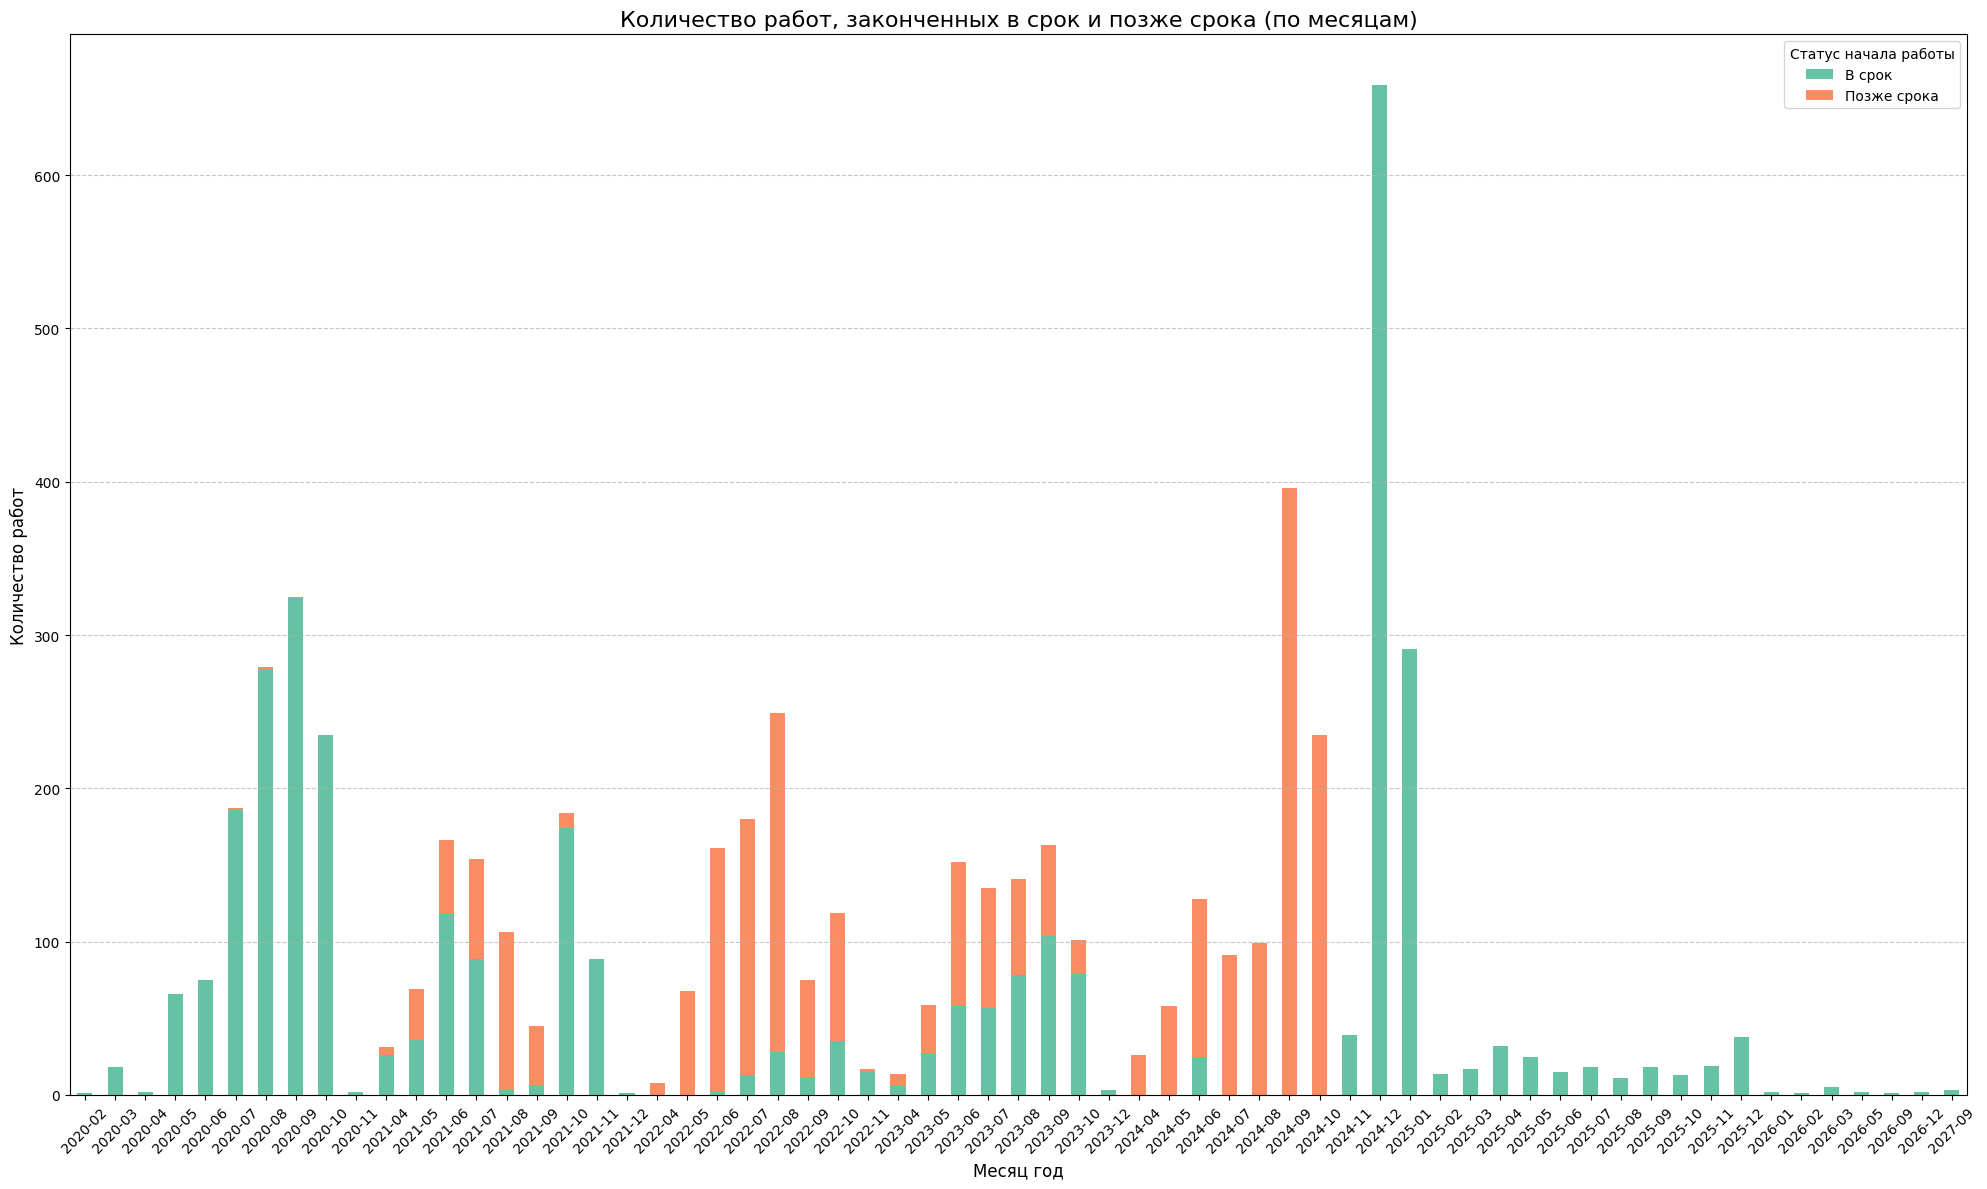

In [ ]:
status_counts = df.groupby(['YearMonthActualEndDate', 'StatusEnd']).size().unstack(fill_value=0)

status_counts.plot(kind='bar', stacked=True, figsize=(20, 12), color=['#66c2a5', '#fc8d62'])

plt.title('Количество работ, законченных в срок и позже срока (по месяцам)', fontsize=16)
plt.xlabel('Месяц год', fontsize=12)
plt.ylabel('Количество работ', fontsize=12)
plt.legend(title='Статус начала работы')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


Количество ремонтируемых дорог по округам

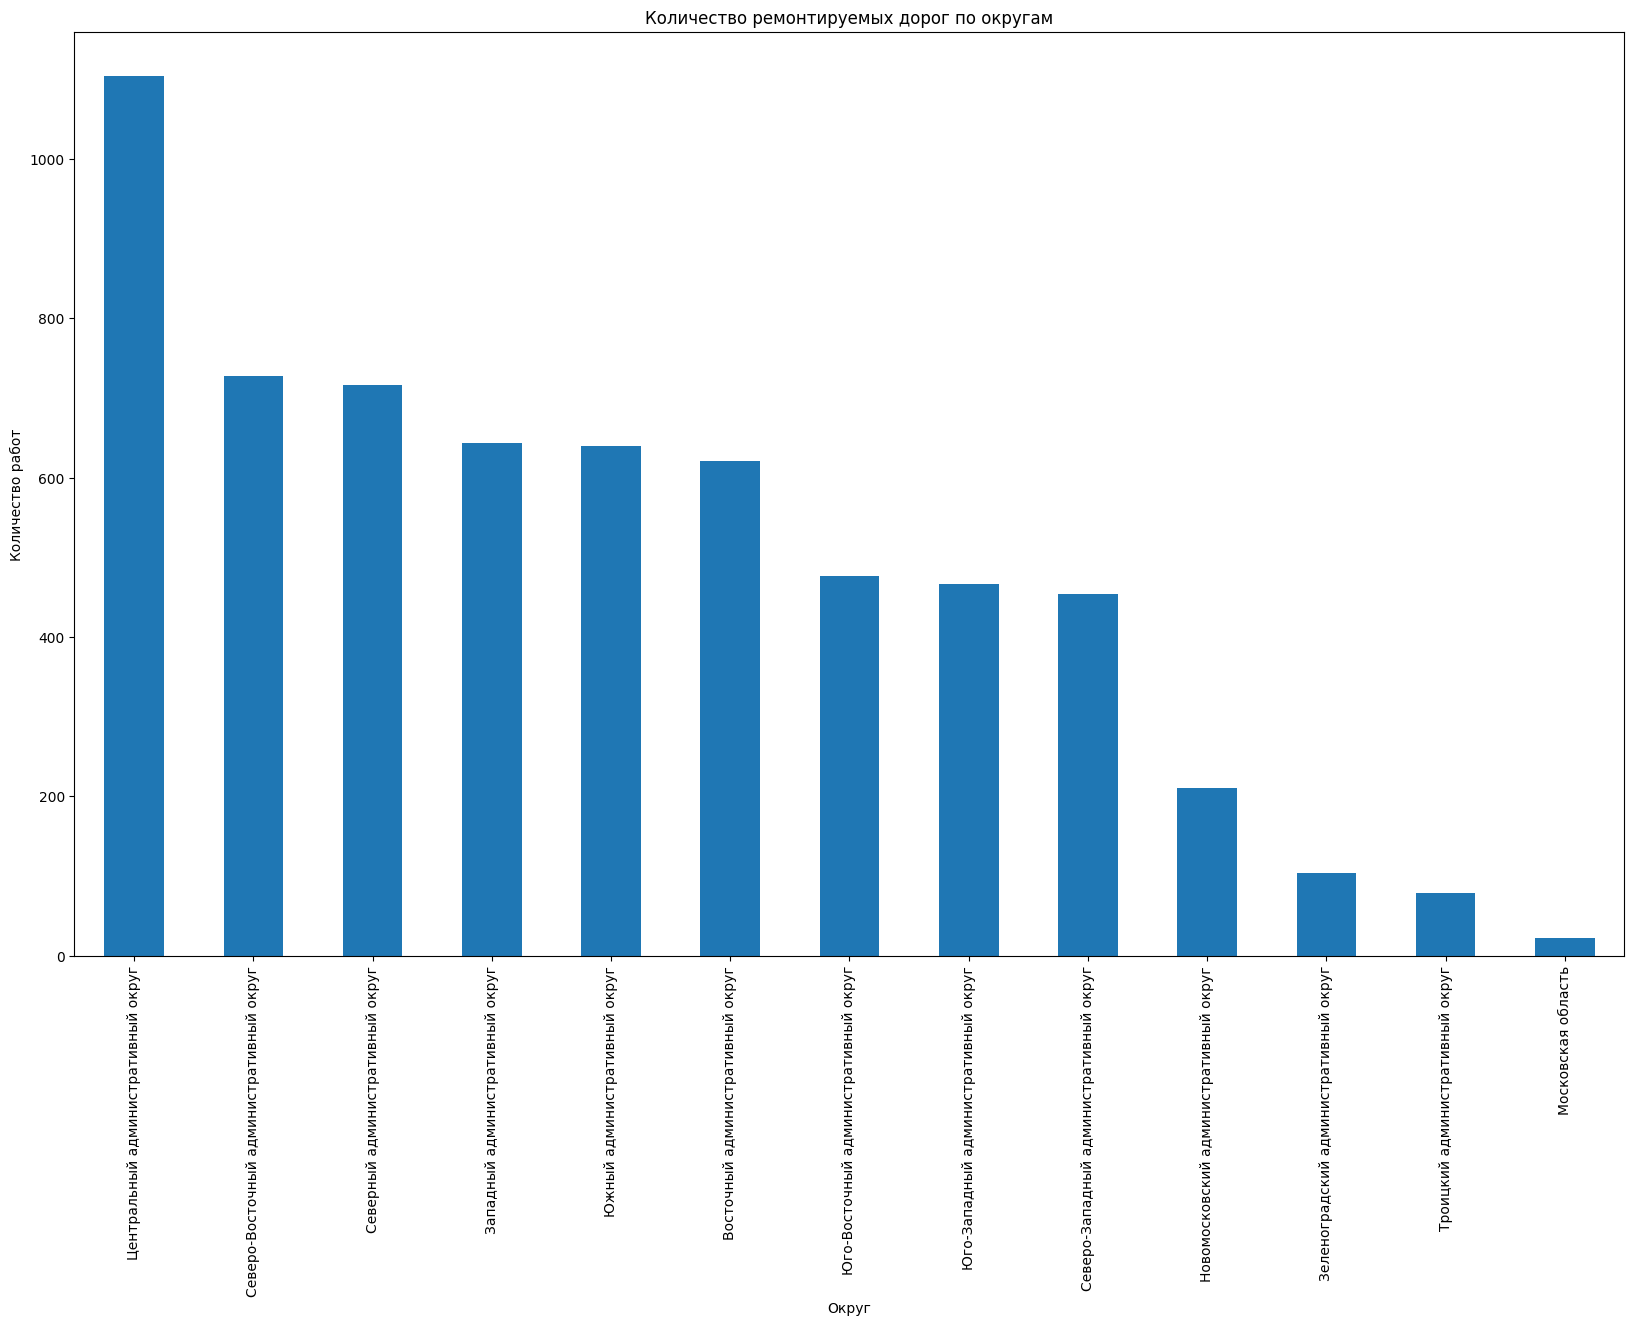

In [ ]:
plt.figure(figsize=(20, 12))
df['AdmArea'].value_counts().sort_index().sort_values(ascending=False).plot(kind='bar')
plt.title('Количество ремонтируемых дорог по округам')
plt.xlabel('Округ')
plt.ylabel('Количество работ')
plt.show()

Количество активных работ по месяцам

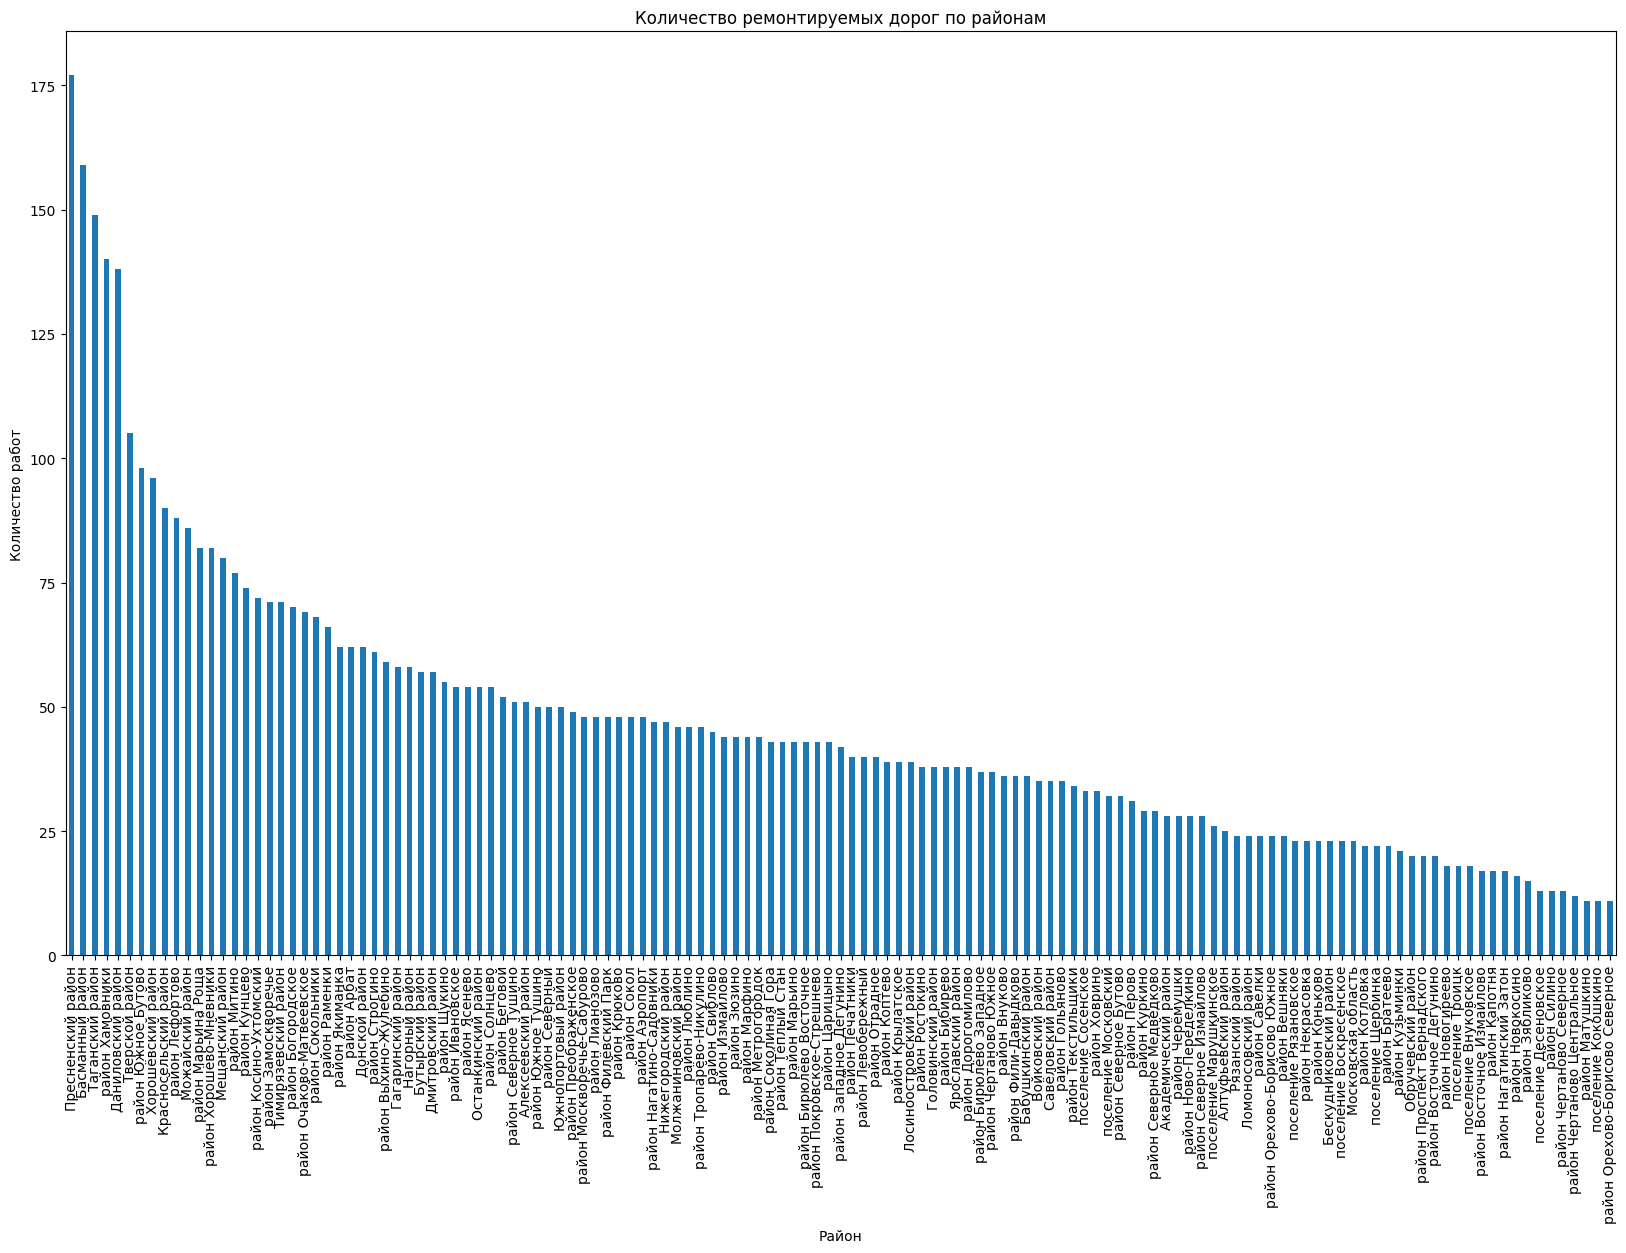

In [ ]:
plt.figure(figsize=(20, 12))
district_counts = df['District'].value_counts().sort_index()
district_counts[district_counts > 10].sort_values(ascending=False).plot(kind='bar')

plt.title('Количество ремонтируемых дорог по районам')
plt.xlabel('Район')
plt.ylabel('Количество работ')
plt.show()

Длина ремонтируемых дорог по окргуам

In [ ]:
def get_list_coordinates(coords_text):
  coordinates = []
  for pair in coords_text.split("], ["):
      clean_pair = pair.replace("[", "").replace("]", "").strip()
      tmp = [float(coord) for coord in clean_pair.split(",")]
      tmp[0], tmp[1] = tmp[1], tmp[0]
      coordinates.append(tmp)
  return coordinates

In [ ]:
from geopy.distance import geodesic

def calculate_path_length(coords_text):
    total_distance = 0.0
    coords = get_list_coordinates(coords_text)
    for i in range(len(coords) - 1):
        total_distance += geodesic(coords[i][::-1], coords[i + 1][::-1]).kilometers
    return total_distance

df['LengthKm'] = df['geoData'].apply(calculate_path_length)

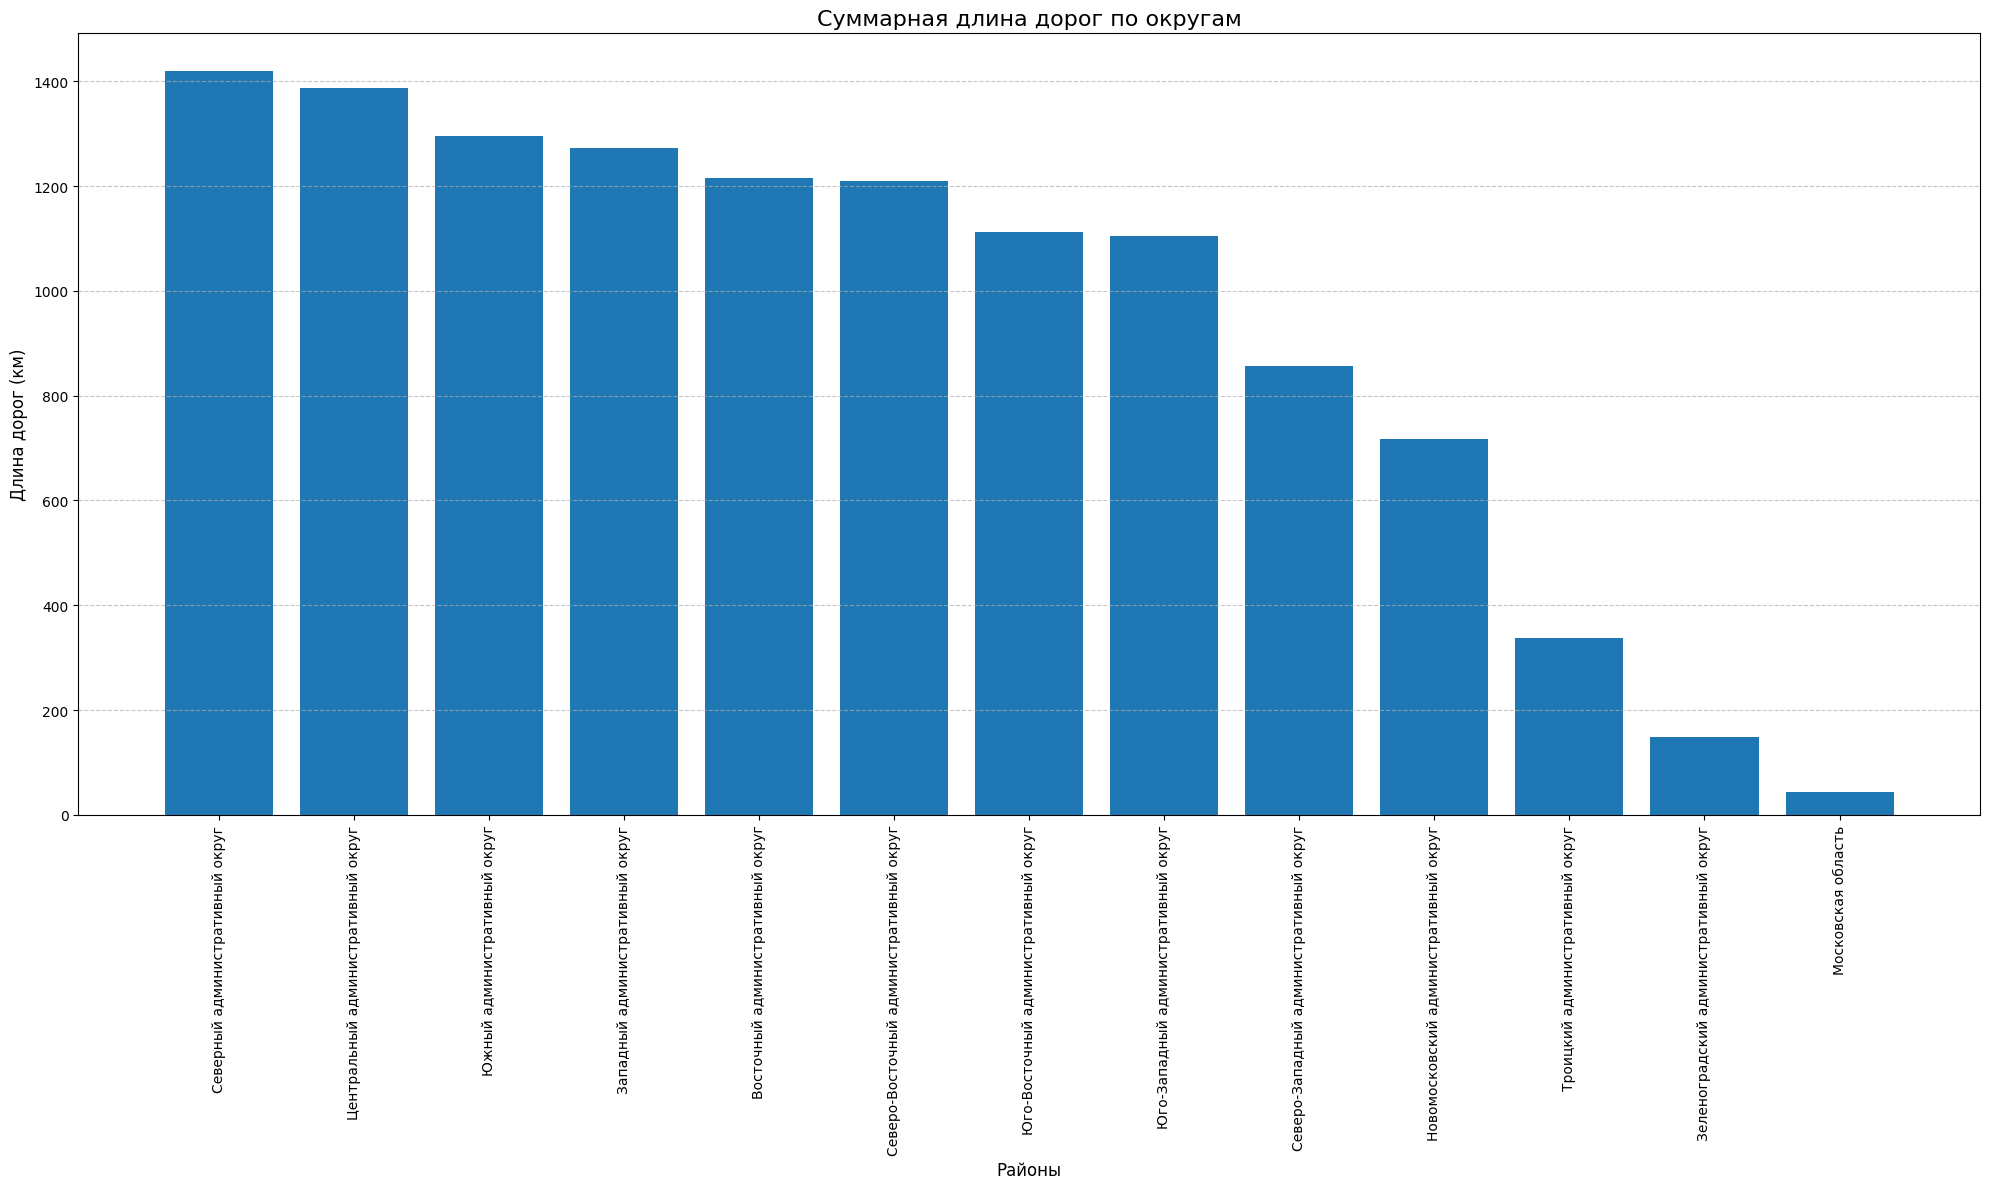

In [ ]:
plt.figure(figsize=(20, 12))
district_lengths = df.groupby('AdmArea')['LengthKm'].sum().reset_index()
district_lengths.columns = ['AdmArea', 'TotalLengthKm']
district_lengths = district_lengths.sort_values(by='TotalLengthKm', ascending=False)

plt.bar(district_lengths['AdmArea'], district_lengths['TotalLengthKm'])

plt.title('Суммарная длина дорог по округам', fontsize=16)
plt.xlabel('Районы', fontsize=12)
plt.ylabel('Длина дорог (км)', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

Длина ремонтируемых дорог по районам

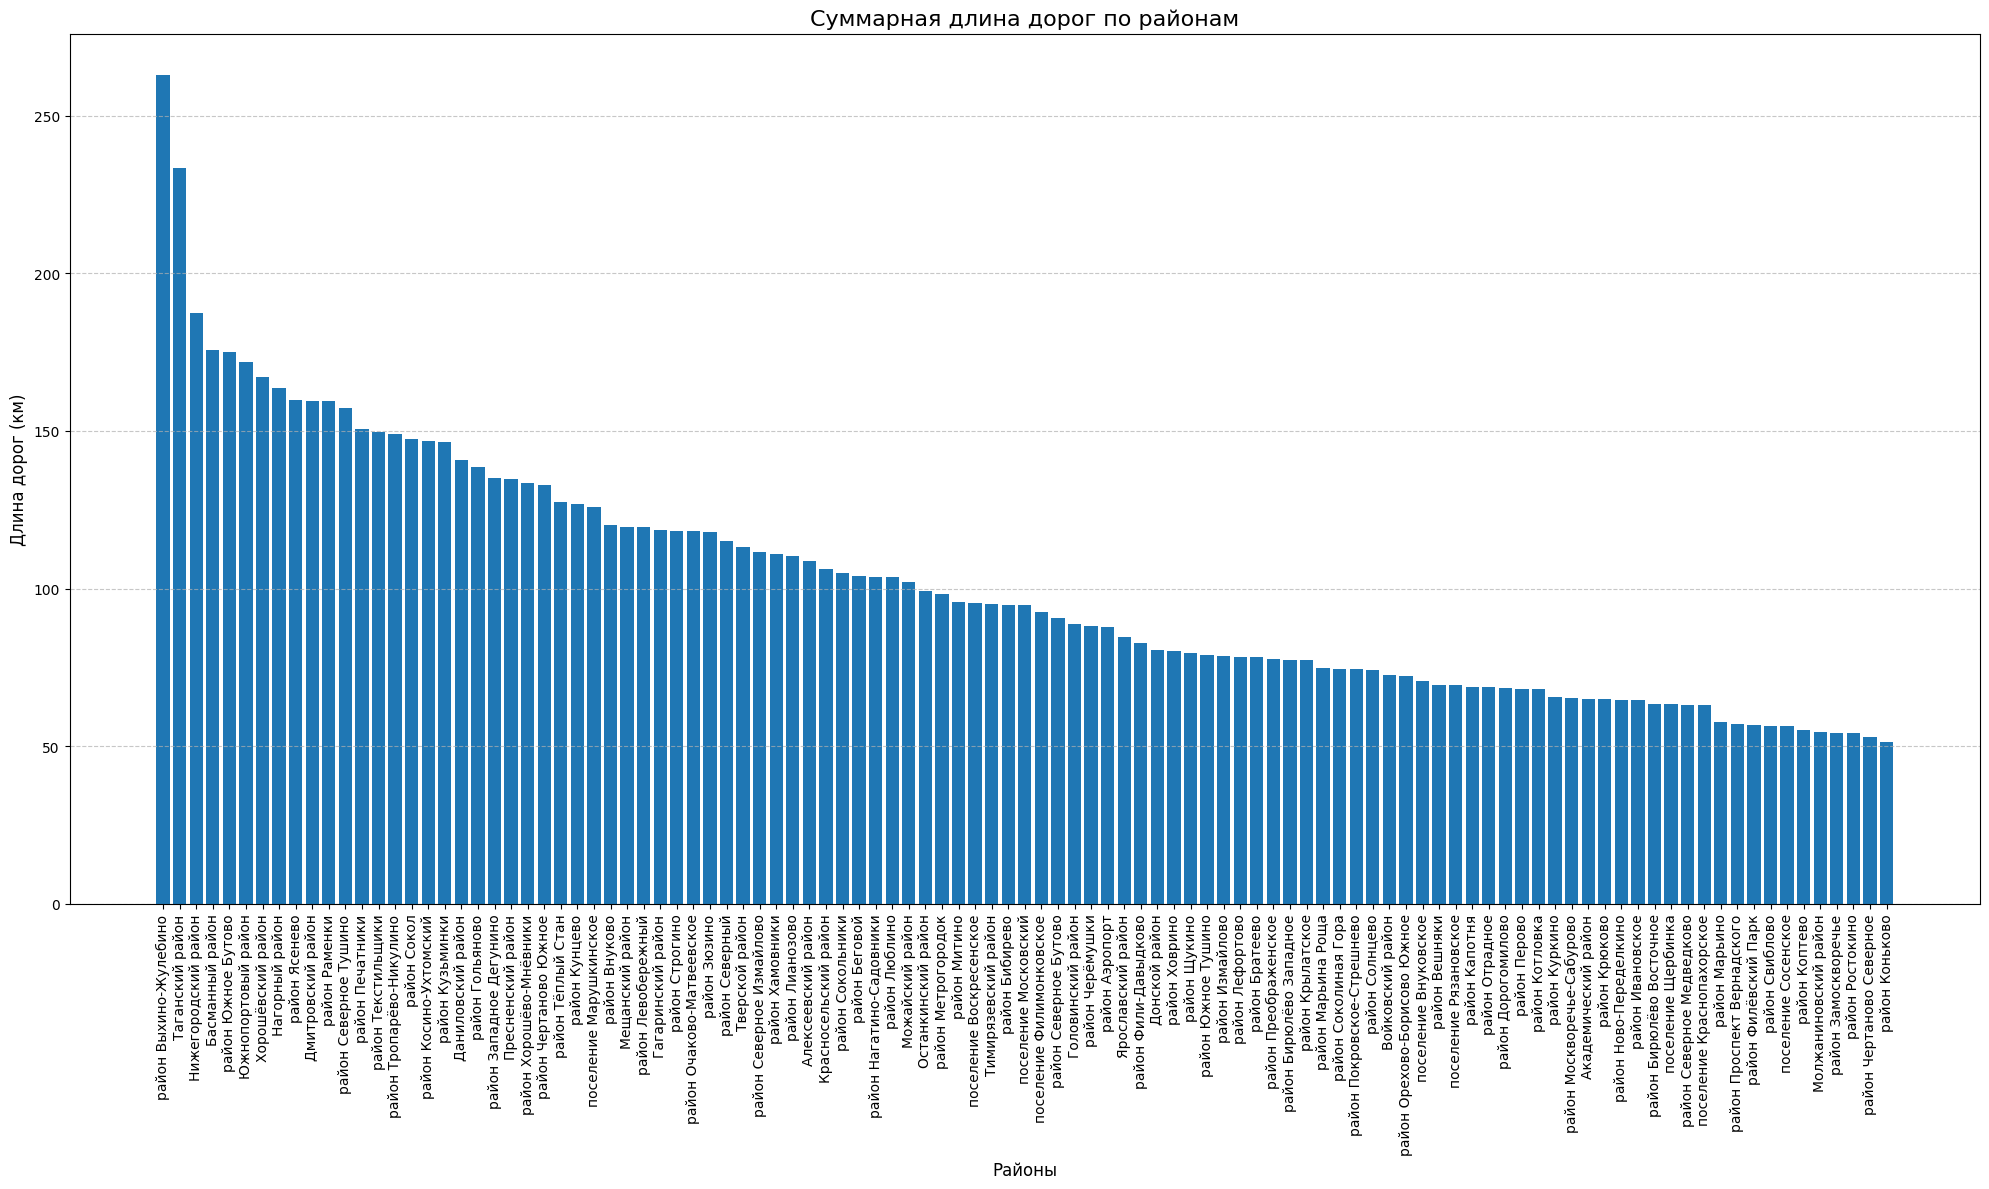

In [ ]:
plt.figure(figsize=(20, 12))
district_lengths = df.groupby('District')['LengthKm'].sum().reset_index()
district_lengths.columns = ['District', 'TotalLengthKm']
district_lengths = district_lengths[district_lengths['TotalLengthKm'] > 50].sort_values(by='TotalLengthKm', ascending=False)

plt.bar(district_lengths['District'], district_lengths['TotalLengthKm'])

plt.title('Суммарная длина дорог по районам', fontsize=16)
plt.xlabel('Районы', fontsize=12)
plt.ylabel('Длина дорог (км)', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

# Карта

Карта. Построение ломаной. Выбор слоев по округам.

In [ ]:
m = folium.Map(location=[55.7558, 37.6173], zoom_start=11)

layer_groups = {}

# Проход по всем строкам DataFrame
for idx, row in df.iterrows():
    coords_text = row['geoData']
    adm_area = row['AdmArea']
    district = row['District']

    if pd.notna(coords_text):
        # Преобразование строки координат в список точек
        coordinates = []
        for pair in coords_text.split("], ["):
            clean_pair = pair.replace("[", "").replace("]", "").strip()
            tmp = [float(coord) for coord in clean_pair.split(",")]
            tmp[0], tmp[1] = tmp[1], tmp[0]
            coordinates.append(tmp)

        # Создание слоя для административного округа, если его еще нет
        if adm_area not in layer_groups:
            layer_groups[adm_area] = {}

        # Создание слоя для района, если его еще нет
        if district not in layer_groups[adm_area]:
            layer_groups[adm_area][district] = folium.FeatureGroup(name=district)

        # Добавление линии в слой района
        folium.PolyLine(
            locations=coordinates,
            color='blue',
            weight=3,
            popup=f"{row['Address']} ({row['WorksType']})"
        ).add_to(layer_groups[adm_area][district])

# Добавление всех слоев на карту
for adm_area, districts in layer_groups.items():
    # Создаем общий слой для административного округа
    adm_area_group = folium.FeatureGroup(name=adm_area)

    for district, layer in districts.items():
        adm_area_group.add_child(layer)  # Добавляем слой района в общий слой округа

    adm_area_group.add_to(m)  # Добавляем общий слой округа на карту

# Добавление переключателя слоев
folium.LayerControl().add_to(m)


# Сохранение карты
m.save('map_all.html')

Карта. Построение ломаной. Выбор слоев по округам. Фильтрация по времени (только текущие ремонтные работы)

In [5]:
m = folium.Map(location=[55.7558, 37.6173], zoom_start=11)

layer_groups = {}

df_now = df[df.WorksStatus == 'идут']

# Проход по всем строкам DataFrame
for idx, row in df_now.iterrows():
    coords_text = row['geoData']
    adm_area = row['AdmArea']
    district = row['District']

    if pd.notna(coords_text):
        # Преобразование строки координат в список точек
        coordinates = []
        for pair in coords_text.split("], ["):
            clean_pair = pair.replace("[", "").replace("]", "").strip()
            tmp = [float(coord) for coord in clean_pair.split(",")]
            tmp[0], tmp[1] = tmp[1], tmp[0]
            coordinates.append(tmp)

        # Создание слоя для административного округа, если его еще нет
        if adm_area not in layer_groups:
            layer_groups[adm_area] = {}

        # Создание слоя для района, если его еще нет
        if district not in layer_groups[adm_area]:
            layer_groups[adm_area][district] = folium.FeatureGroup(name=district)

        # Добавление линии в слой района
        folium.PolyLine(
            locations=coordinates,
            color='blue',
            weight=3,
            popup=f"{row['Address']} ({row['WorksType']})"
        ).add_to(layer_groups[adm_area][district])

# Добавление всех слоев на карту
for adm_area, districts in layer_groups.items():
    # Создаем общий слой для административного округа
    adm_area_group = folium.FeatureGroup(name=adm_area)

    for district, layer in districts.items():
        adm_area_group.add_child(layer)  # Добавляем слой района в общий слой округа

    adm_area_group.add_to(m)  # Добавляем общий слой округа на карту

# Добавление переключателя слоев
folium.LayerControl().add_to(m)


# Сохранение карты
m.save('map_all_now.html')